In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Tarefa 4 - Decision Trees, Random Forest and K-Means
Fourth assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using decision trees and random forests to solve a real-world problem in classification and delve into the world of unsupervised learning by implementing the K-means algorithm. Students will also get used to generating important plots during training to analyse the models' behaviour. 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).

## Notebook Overview:

1. [Decision Trees](#Decision_Trees) (30%)
2. [Random Forest](#Random_Forest) (30%)
3. [K-Means](#K-Means) (30%)

### Decision_Trees
## Part 1 - Decision Trees for Classification (value: 30%)

In [2]:
# load the data
ddi_df = pd.read_csv('data/ddi_dt_sample.csv') # don't forget to change the path

In [3]:
# inspect the data
ddi_df.head(5)

,drug1,drug2,ddi,pca_max_0,pca_max_1,pca_max_2,pca_max_3,pca_max_4,pca_max_5,pca_max_6,...,pca_min_17,pca_min_18,pca_min_19,pca_min_20,pca_min_21,pca_min_22,pca_min_23,pca_min_24,pca_min_25,pca_min_26
0,CID000002725,CID000013342,0.0,-2.383210,-0.066904,0.051153,0.058145,0.398508,0.215271,-0.267814,...,-0.36635,-1.091191,-1.021989,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.09133,-0.195522
1,CID000002802,CID000013342,0.0,-2.554958,-0.066904,0.053715,0.058145,0.398508,0.131852,-0.267814,...,-0.36635,0.106596,0.010149,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522
2,CID000002083,CID000013342,0.0,9.908402,-0.066904,0.122384,0.058145,0.398508,0.098734,0.041276,...,-0.36635,0.102901,0.010149,-0.088365,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522
3,CID000004034,CID000013342,0.0,-2.547375,-0.066904,0.051884,0.058145,0.398508,0.203962,-0.267814,...,-0.36635,-1.011102,-0.944133,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522
4,CID000003899,CID000013342,0.0,-2.554958,-0.066904,0.051083,0.058145,0.398508,0.138126,-0.267814,...,-0.36635,0.075010,0.010149,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522


As you can observe, the first 2 columns represent the IDs of the drugs in each combination. The 3rd column represents the binary label indicating if the pair causes an adverse interaction or not. The remaining 54 columns are the features based on the PCA representations of individual drug targets. 

In [4]:
#Functions

###----- criterions -----###
def se_criterion(region):
    """
    Implements the sum of squared error criterion in a region
    
    Parameters
    ----------
    region : ndarray
        Array of shape (N,) containing the values of the target values 
        for N datapoints in the training set.
    
    Returns
    -------
    float
        The sum of squared error
        
    Note
    ----
    The error for an empty region should be infinity (use: float("inf"))
    This avoids creating empty regions
    """
    # your code here
    if len(region) == 0:
        return float("inf")
    
    if isinstance(region, pd.DataFrame) or isinstance(region, pd.Series):
        region = region.values
    
    mean_value = np.mean(region)
    squared_errors = (region - mean_value) ** 2
    return np.sum(squared_errors)

#Classes
class DecisionTree:
    def __init__(self, criterion = se_criterion, max_depth=4, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None

    def fit(self, X_train, y_train):
        train_data = np.column_stack((X_train, y_train))  # 
        self.tree = self.create_tree(train_data, 0)  # 

    def predict(self, X_test):
        predictions = np.array([self._predict_sample(x, self.tree) for x in X_test])
        return predictions
    
    def print_tree(self):
        self._print_tree(self.tree)

    def create_tree(self, data, current_depth):
        if current_depth > self.max_depth:
            return None
        
        split_data, split_feature_idx, split_feature_val = self.find_bestsplit(data)

        node = TreeNode(data, split_feature_idx, split_feature_val, self.criterion(data[:,-1])/data.shape[0])
        
        if split_data is None: #
            return node
        
        if len(split_data[0]) <= self.min_samples_leaf or len(split_data[1]) <= self.min_samples_leaf:
            return node

        current_depth += 1
        node.left = self.create_tree(split_data[0], current_depth)
        node.right = self.create_tree(split_data[1], current_depth)

        return node

    def find_bestsplit(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.values
        if isinstance(data, pd.Series):
            data = data.values
        
        best_sq_error = float('inf')
        best_feature_index = None
        best_tau = None
        regions = None

        _, n_features = data.shape
        
        for feature_index in range(n_features - 1): 
            feature_values = data[:, feature_index]
            possible_taus = np.unique(feature_values) #
            
            for tau in possible_taus:
                left, right = self.split(data, feature_index, tau)
                sq_error = self.criterion(left[:, -1]) + self.criterion(right[:, -1])
                
                if sq_error < best_sq_error and\
                len(left)>self.min_samples_leaf and\
                len(right)>self.min_samples_leaf: #
                    best_sq_error = sq_error
                    best_feature_index = feature_index
                    best_tau = tau
                    regions = (left, right)

        return regions, best_feature_index, best_tau

    def split(self, data, feature_index, tau, indices = False):
        if isinstance(data, pd.DataFrame):
            feature_values = data.iloc[:, feature_index].values
        else:
            feature_values = data[:, feature_index]
            
        left_indices = np.where(feature_values <= tau)[0] 
        right_indices = np.where(feature_values > tau)[0] 
        
        if indices: #
            return left_indices, right_indices
        
        #
        left_partition = data[left_indices]
        right_partition = data[right_indices]
        
        return left_partition, right_partition

    def _predict_sample(self, sample, node):
        if node.is_leaf:
            return np.mean(node.data[:, -1]) # 
        if sample[node.feature_idx] < node.feature_val:
            return self._predict_sample(sample, node.left)
        else:
            return self._predict_sample(sample, node.right)

    def _print_tree(self, node, depth=0, prefix=""):
        if node is None:
            return
        indent = "  " * depth
        if node.is_leaf:
            print(f"{indent}{prefix}Leaf: Predict {np.mean(node.data[:, -1]):.2f}, Samples: {len(node.data)}, sq_error = {node.sq_error:.2f}")
        else:
            print(f"{indent}{prefix}Node: Feature {node.feature_idx}, Threshold {node.feature_val:.2f}, sq_error = {node.sq_error:.2f}")
            self._print_tree(node.left, depth + 1, prefix="L--> ")
            self._print_tree(node.right, depth + 1, prefix="R--> ")

class TreeNode:
    def __init__(self, data, feature_idx, feature_val, sq_error):
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.sq_error = sq_error
        self.left = None
        self.right = None

    @property
    def is_leaf(self):
        return self.left is None and self.right is None

In [5]:
## your code goes here:



## Random_Forest
## Part 2 - Random Forest for Classification Networks (value: 30%)



In [6]:
## your code goes here:

## K-Means
## Part 3 – Clustering with K-means (value: 40%)

In this exercise, you will explore clustering by implementing the K-means algorithm. You will write code to perform K-means clustering while visualizing the movement of the centroids at each iteration. 

To complete this exercise, you will write code to implement K-means for clustering: 

1. Dataset Preparation: Run the cells provided in the notebook that generate the artificial data points for this exercise.
2. K-means Clustering:
	- Initialize K cluster centroids by selecting K points from your dataset at random.
	- Implement a loop to perform the following steps until convergence (or until a specified maximum number of iterations is reached, e.g., 150):
        - Assign each data point to the nearest centroid (you will have to calculate the Euclidean distance between the data point and each centroid).
        - Update each centroid by moving it to the mean of all data points assigned to it.
        - Check for convergence by comparing the new centroids with the previous centroids. If the difference is smaller than an $\epsilon=1^{-4}$, exit the loop.
3. Centroid Movement Visualization:
	- At 5 different moments during training, plot a figure showing the centroids and the points. Figure 1 should show the situation at the beginning, before learning. Figure 5 should show the situation at the end of the learning. The remaining Figures 2-4 should show intermediary situations.
	- For each figure, each centroid will be represented by a large black cross and each cluster with a different colour, the points must be coloured according to their respective cluster.
4. Sum of squared distances:
	- Along with plotting the centroid movement, calculate the sum of squared distances at each iteration as follows:
        - $\sum_{j=1}^K \sum_{n \in S_j}d(x_n,\mu_j )^2$, where $K$ is the number of clusters, $x_n$ represents the $n^{th}$ datapoint, $n \in S_j$ indicates a set of points that belong to cluster $S_j$, $\mu_j$ is the mean of the datapoints in $S_j$ and $d(x_n,\mu_j)$ indicates the Euclidean distance between $x_n$ and $\mu_j$.
	- Make a plot of the sum of squared distances at each iteration. 


In [7]:
# Generate artificial data points
np.random.seed(13)
num_samples = 200
num_features = 2
X = np.random.randn(num_samples, num_features) * 1.5 + np.array([[2, 2]])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 3 + np.array([[-5, -5]])])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 2 + np.array([[7, -5]])])

In [37]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=150):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels_ = None
        self.ss_distances = []

    def fit(self, X):
        # Step 1: Initialize K cluster centroids by selecting K points from your dataset at random.
        initial_centroids_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[initial_centroids_indices]

        for iteration in range(self.max_iter):
            # Step 2a: Assign each data point to the nearest centroid
            distances = np.array([[np.linalg.norm(x - centroid) for centroid in self.centroids] for x in X])
            self.labels_ = np.argmin(distances, axis=1)
            self.ss_distances.append(sum([np.linalg.norm(X[self.labels_ == k] - self.centroids[k])**2 for k in range(self.n_clusters)]))

            # Step 2b: Update each centroid by moving it to the mean of all data points assigned to it
            new_centroids = np.array([X[self.labels_ == k].mean(axis=0) for k in range(self.n_clusters)])
            
            # Step 2c: Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break
            self.centroids = new_centroids
            
            self.plot_clusters(X, iteration + 1)

        # Final plot
        self.plot_clusters(X, 'final')

    def plot_clusters(self, X, iteration):
        plt.figure(figsize=(8, 6))
        for k in range(self.n_clusters):
            cluster_points = X[self.labels_ == k]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids')
        plt.title(f'Iteration {iteration}')
        plt.legend()
        plt.show()
    
    def plot_sum_of_squared_distances(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.ss_distances) + 1), self.ss_distances, marker='o', color='b')
        plt.title('Sum of Squared Distances')
        plt.xlabel('Iteration')
        plt.ylabel('SSD')
        plt.grid(True, alpha=0.2)
        plt.show()

In [53]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=150):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels_ = None
        self.ss_distances = []
        self.iteration_data = []

    def fit(self, X):
        # Step 1: Initialize K cluster centroids by selecting K points from your dataset at random.
        initial_centroids_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[initial_centroids_indices]
        
        for iteration in range(self.max_iter):
            # Step 2a: Assign each data point to the nearest centroid
            distances = np.array([[np.linalg.norm(x - centroid) for centroid in self.centroids] for x in X])
            self.labels_ = np.argmin(distances, axis=1)

            # Step 2b: Update each centroid by moving it to the mean of all data points assigned to it
            new_centroids = np.array([X[self.labels_ == k].mean(axis=0) for k in range(self.n_clusters)])
            
            # Step 2c: Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break
            
            # Save distance data for plotting later
            self.ss_distances.append(sum([np.linalg.norm(X[self.labels_ == k] - self.centroids[k])**2 for k in range(self.n_clusters)]))

            # Save iteration data for plotting later
            self.iteration_data.append((self.centroids.copy(), self.labels_.copy()))

            self.centroids = new_centroids
        
        # Plot the required iterations
        num_iterations = len(self.iteration_data)
        print(f"O número de iterações necessárias para convergencia foi: {num_iterations}")
        steps = [0, num_iterations // 4, num_iterations // 2, 3 * num_iterations // 4, num_iterations - 1]
        for i, step in enumerate(steps):
            centroids, labels = self.iteration_data[step]
            iteration_label = 'begin' if step == 0 else ('final' if step == num_iterations - 1 else step + 1)
            self.plot_clusters(X, centroids, labels, iteration=iteration_label)

    def plot_clusters(self, X, centroids, labels, iteration):
        plt.figure(figsize=(8, 6))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}')
        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids')
        plt.title(f'Iteration {iteration}')
        plt.legend()
        plt.show()

    def plot_sum_of_squared_distances(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.ss_distances) + 1), self.ss_distances, marker='o', color='b')
        plt.title('Sum of Squared Distances')
        plt.xlabel('Iteration')
        plt.ylabel('SSD')
        plt.grid(True, alpha=0.2)
        plt.show()

O número de iterações necessárias para convergencia foi: 11


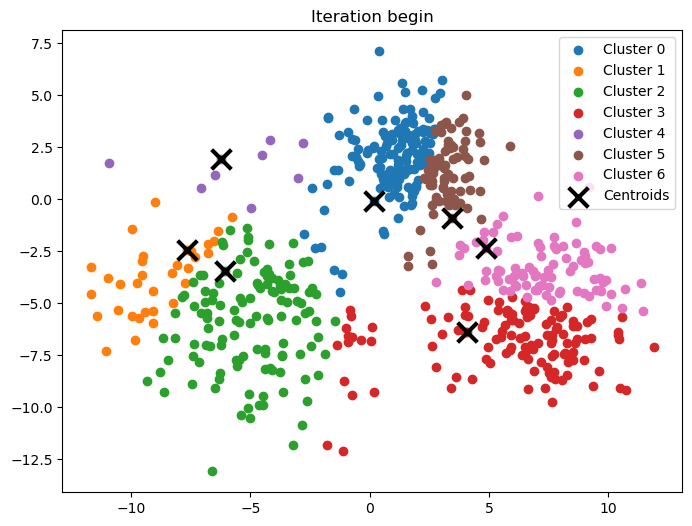

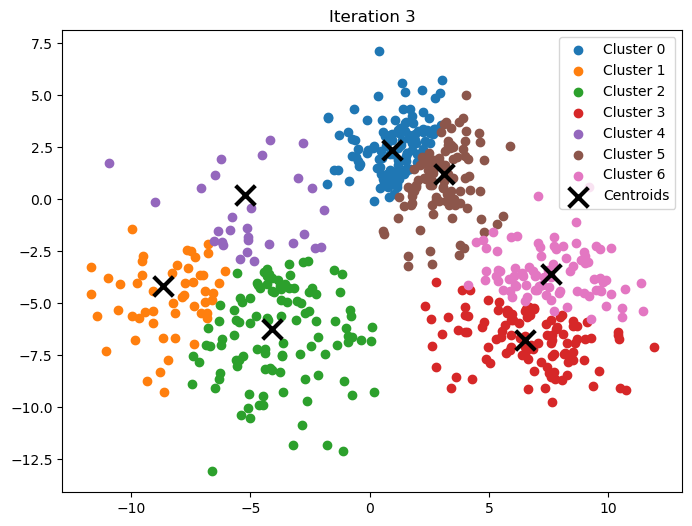

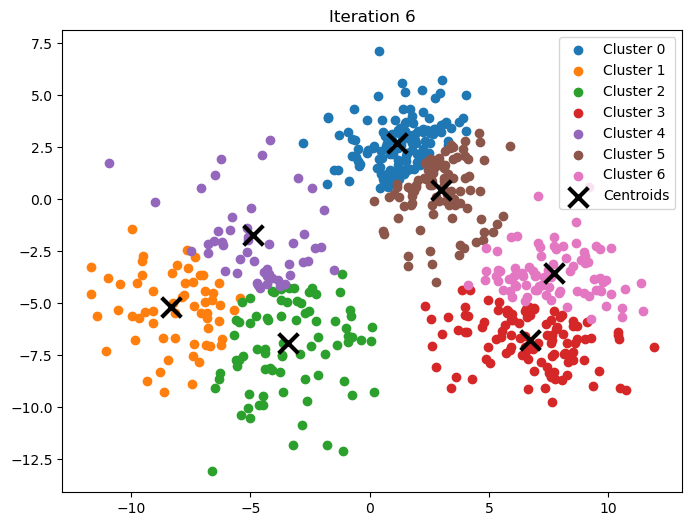

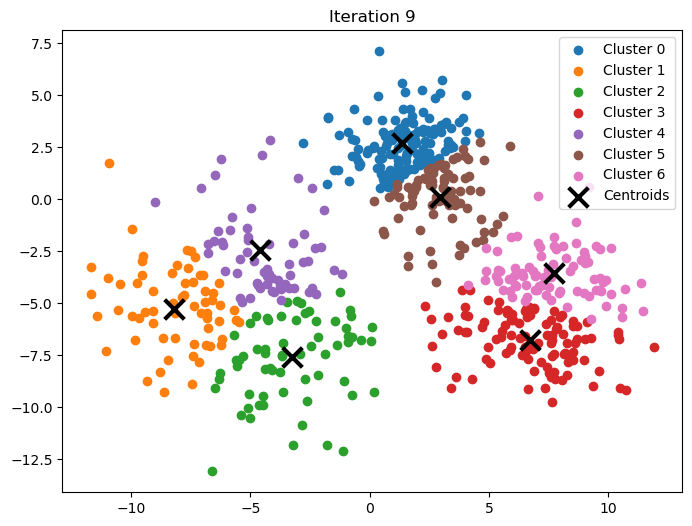

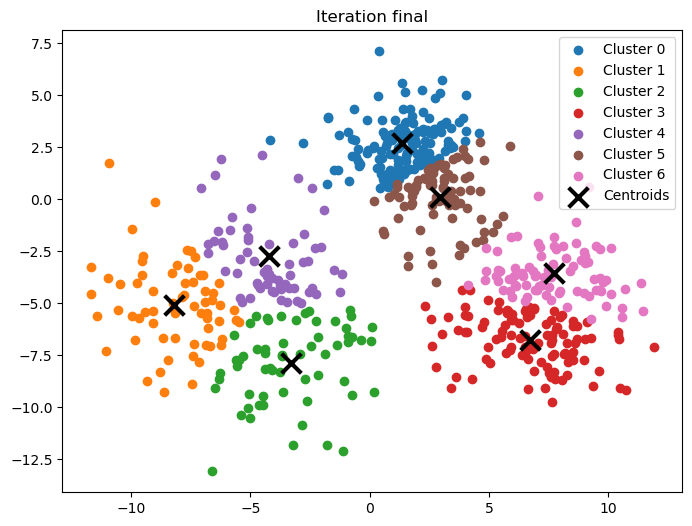

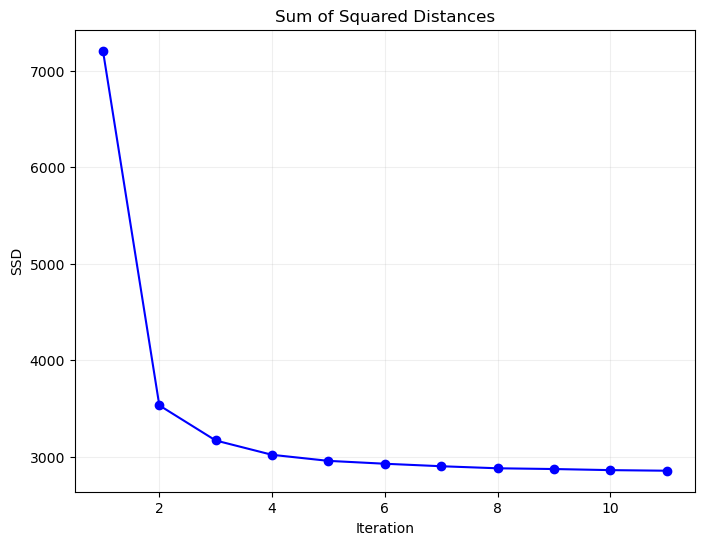

In [55]:
## your code goes here:
kmeans = KMeans(n_clusters=7, max_iter=150)
kmeans.fit(X)

# Plot sum of squared distances
kmeans.plot_sum_of_squared_distances()